In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sudha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sudha\AppData\Roaming\nltk_data...


In [2]:
df = pd.read_csv(r"C:\Users\Sudha\Downloads\chatgpt_style_reviews_dataset.xlsx - Sheet1.csv")
df = df.dropna(subset=['review', 'rating'])

In [3]:
def map_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['rating'].apply(map_sentiment)

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(clean_text)


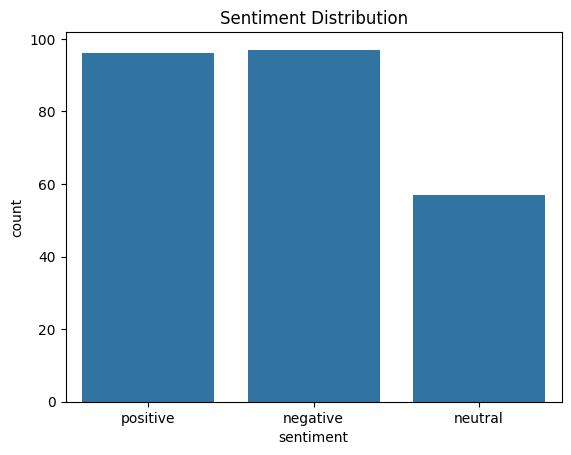

In [5]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


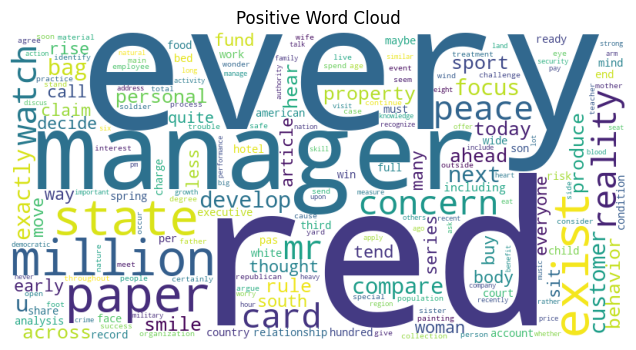

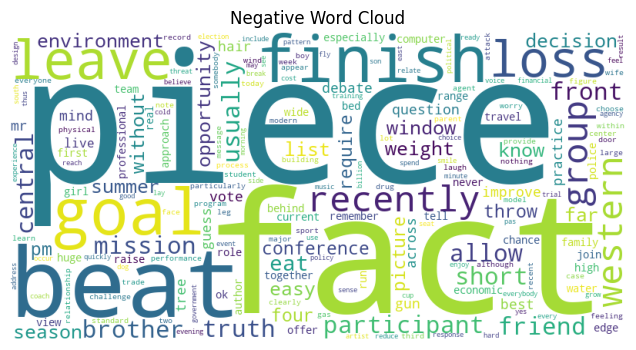

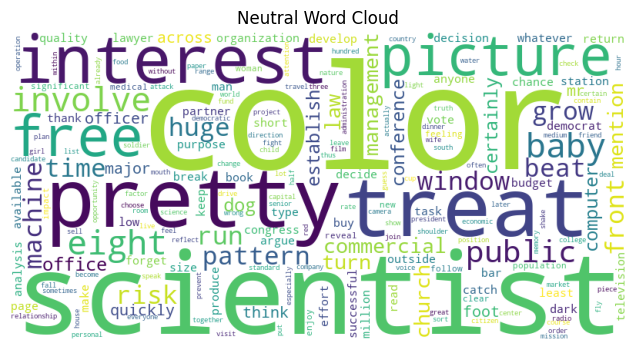

In [6]:
for s in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == s]['clean_review'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f"{s.capitalize()} Word Cloud")
    plt.show()


In [7]:
X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [8]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
models = {
    "Naive Bayes": nb,
    "Logistic Regression": lr,
    "Random Forest": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Naive Bayes
Accuracy: 0.4
              precision    recall  f1-score   support

    negative       0.37      0.53      0.43        19
     neutral       0.00      0.00      0.00        12
    positive       0.43      0.53      0.48        19

    accuracy                           0.40        50
   macro avg       0.27      0.35      0.30        50
weighted avg       0.31      0.40      0.35        50


Logistic Regression
Accuracy: 0.44
              precision    recall  f1-score   support

    negative       0.40      0.53      0.45        19
     neutral       0.00      0.00      0.00        12
    positive       0.48      0.63      0.55        19

    accuracy                           0.44        50
   macro avg       0.29      0.39      0.33        50
weighted avg       0.33      0.44      0.38        50


Random Forest
Accuracy: 0.36
              precision    recall  f1-score   support

    negative       0.37      0.58      0.45        19
     neutral       0.00      0.00   

s:\vs code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\vs code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\vs code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\vs code\.venv\Lib\site-packages\sklearn\metrics\_

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [13]:
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y))

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_review'])
seq = tokenizer.texts_to_sequences(df['clean_review'])
X_pad = pad_sequences(seq, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_enc, test_size=0.2, random_state=42
)


In [27]:
model = Sequential([
    Embedding(5000, 128, input_length=100),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - accuracy: 0.3063 - loss: 1.0987 - val_accuracy: 0.4000 - val_loss: 1.0884
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6375 - loss: 1.0805 - val_accuracy: 0.3500 - val_loss: 1.0759
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7437 - loss: 1.0601 - val_accuracy: 0.3750 - val_loss: 1.0610
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7500 - loss: 1.0358 - val_accuracy: 0.4000 - val_loss: 1.0374
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7437 - loss: 1.0043 - val_accuracy: 0.3250 - val_loss: 1.0256
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7375 - loss: 0.9612 - val_accuracy: 0.3500 - val_loss: 1.0314
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7500 - loss: 0.9024 - val_accuracy: 0.4250 - val_loss: 1.0140
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7812 - loss: 0.8208 - val_accuracy: 0.4000 - v

In [29]:
import pickle

# Save trained TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save trained sentiment model (Logistic / NB / RF)
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(lr, f)   # replace lr with your model variable
